In [1]:
# Seminarfacharbeit Informatik Klasse 10: Errechnung von Strukturmerkmalen organischer Verbindungen auf Basis von IR-Spektren mit Hilfe künstlicher neuronaler Netze
# Datum: 31.05.23
# Autoren: Albert-V. Meyer, Joshua Schraud, Paula Kaltwasser

# benötigte Module importieren
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import time

# nimmt vom Benutzer die Pfade für den Test- und Traingsdatensatz entgegen
path_train = str(input("Bitte geben Sie den Pfand der Datei des verwendeten Trainingsdatensatzes an (nicht in Anführungszeichen schreiben)."))
path_test = str(input("Bitte geben Sie den Pfand der Datei des verwendeten Testdatensatzes an (nicht in Anführungszeichen schreiben)."))

Bitte geben Sie den Pfand der Datei des verwendeten Trainingsdatensatzes an (nicht in Anführungszeichen schreiben).C:\Users\Joshua\OneDrive\Dokumente\Seminarfach_10\Trainings- und Testdaten_IR\IR_Trainingsdatensatz_vollständig.csv
Bitte geben Sie den Pfand der Datei des verwendeten Testdatensatzes an (nicht in Anführungszeichen schreiben).C:\Users\Joshua\OneDrive\Dokumente\Seminarfach_10\Trainings- und Testdaten_IR\IR_Testdatensatz.csv


In [2]:
# Zeitpunkt des Beginns messen
time1 = time.time()

# Funktion, die die Daten für das Training des Netzes aus der CSV-Datei ausliest, verarbeitet und aufbereitet
def get_train_data(x):
    
    # CSV-Datei wird geöffnet, ausgelesen und wieder geschlossen
    test_data_file = open(path_train, 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()

    # Listen für Eingabe- und Zielwerte für das Training
    x_train_list = []
    y_train_list = []
    
    # jede Zeile der CSV-Datei (die Daten jedes einzelnen Trainingsmoleküls) wird durchgearbeitet
    for record in test_data_list:
        
        # Daten werden in eine Liste überführt
        all_values = record.split(',')
        values_list = []
        for i in all_values:
            values_list.append(int(i))
            
        # Eingabe- und Zieldaten werden separiert
        y_train_list.append(values_list[x:(x + 1)])
        input_values = values_list[13:]
        
        # Eingabedaten werden um einen Anfangs- und einen Endwert zur Vereinheitlichung ergänzt 
        input_values = [4000, 98] + input_values
        input_values.append(400)
        input_values.append(0)
        
        # Punkte mit ganzzahligen x-Werten der linearen Funktionen zwischen den Banden werden in eine Liste eintragen
        tuple_group = []
        for j in range(len(input_values)):
            if j % 2 == 0 and input_values[j] != 400:
                x1 = input_values[j]
                y1 = input_values[j + 1]
                x2 = input_values[j + 2]
                y2 = input_values[j + 3]
                for k in range(input_values[j], input_values[j + 2], -1):
                    y = ((y2 - y1) / (x2 - x1)) * k + (y1 - ((y2 - y1) / (x2 - x1) * x1))
                    tuple = [k / 4001, y / 100]
                    tuple_group.append(tuple)

        # Eingabewerte für ein Molekül werden in die allgemeine Liste für Trainingseingabewerte eingefügt            
        x_train_list.append(tuple_group)
    
    for i in range(len(y_train_list)):
        if y_train_list[i] == [1]:
            y_train_list[i] = [1, 0]
        if y_train_list[i] == [0]:
            y_train_list[i] = [0, 1]
    
    # Liste für Eingabe- und Zielwerte für das Training wird in den Datentyp Array überführt
    x_train = np.array(x_train_list)
    x_train = x_train.reshape(-1, 3600, 2)
    y_train = np.asarray(y_train_list)
    y_train = y_train.reshape(-1, 2)
    
    # aufbereitete Traingsdaten werden von Funktion zurückgegeben
    return x_train, y_train


# Funktion, die die Daten für das Testen des Netzes aus der CSV-Datei ausliest, verarbeitet und aufbereitet

def get_test_data(x):
    
    # CSV-Datein wird geöffnet, ausgelesen und wieder geschlossen
    test_data_file = open(path_test, 'r')
    test_data_list = test_data_file.readlines()
    test_data_file.close()
    
    # Listen für Eingabe- und Zielwerte für das Testen des Neztes
    x_test_list = []
    y_test_list = []

    # jede Zeile der CSV-Datei (die Daten jedes einzelnen Testmoleküls) wird durchgearbeitet
    for record in test_data_list:
        
        # Eingabe- und Zieldaten werde separiert
        all_values = record.split(',')
        values_list = []
        for i in all_values:
            values_list.append(int(i))
        y_test_list.append(values_list[x:(x + 1)])
        input_values = values_list[13:]
        
        # Eingabedaten werden um einen Anfangs- und einen Endwert zur Vereinheitlichung ergänzt
        input_values = [4000, 98] + input_values
        input_values.append(400)
        input_values.append(0)
        
        # Punkte mit ganzzahligen x-Werten der linearen Funktionen zwischen den Banden in eine Liste eintragen
        
        # Liste für die Eingabewerte eines Moleküls
        tuple_group = []
        for j in range(len(input_values)):
            # für jeden zweiten Wert (x-Werte der Banden) der Eingabeliste abgesehen vom Endwert werden Variablen für x- und y-Werte dieses und des nächsten Punktes festgelegt 
            if j % 2 == 0 and input_values[j] != 400:
                x1 = input_values[j]
                y1 = input_values[j + 1]
                x2 = input_values[j + 2]
                y2 = input_values[j + 3]
                # für alle ganzzahligen x-Werte k zwischen den vorher definierten Punkten wird ein zugehöriger y-Wert für eine lineare Funktion zwischen den Punkten errechnet
                for k in range(input_values[j], input_values[j + 2], -1):
                    y = ((y2 - y1) / (x2 - x1)) * k + (y1 - ((y2 - y1) / (x2 - x1) * x1))
                    # Tupel mit dem x- und y-Wert des Punktes auf der linearen Funktion wird erstellt und an die Liste für die Eingabewerte des Moleküls angehängt
                    tuple = [k / 4001, y / 100]
                    tuple_group.append(tuple)

        # Eingabewerte für ein Molekül werden in die allgemeine Liste für Testeingabewerte eingefügt
        x_test_list.append(tuple_group)

    for i in range(len(y_test_list)):
        if y_test_list[i] == [1]:
            y_test_list[i] = [1, 0]
        if y_test_list[i] == [0]:
            y_test_list[i] = [0, 1]    
    
    # Liste für Eingabe- und Zielwerte für das Testen wird in den Datentyp Array überführt    
    x_test = np.asarray(x_test_list)
    x_test = x_test.reshape(-1, 3600, 2)
    y_test = np.asarray(y_test_list)
    y_test = y_test.reshape(-1, 2)

    # aufbereitete Testdaten werden von Funktion zurückgegeben
    return x_test, y_test

In [3]:
def model_train_and_test(x_train, y_train, x_test, y_test, epoch_num):
    # neuronales Netz mit 5 Schichten
    # die Variable units legt die Anzahl der Knoten pro Schicht fest, mit der Variable activation kann die Aktivierungsfunktion für die jeweilige Schicht festgelegt werden
    model = Sequential()
    # Eingabeschicht mit 16 Knoten
    model.add(Dense(units=16, input_shape=(3600, 2), activation='relu'))
    # die Flatten-Schicht (erste versteckte Schicht) sorgt dafür, dass mehrdimesionale in eindimesionale Eingaben umgewandelt werden
    # in diesem Fall ist die Eingabeform (input_shape) zweidimesional
    model.add(Flatten())
    # zweite versteckte Schicht mit 32 Knoten
    model.add(Dense(units=32, activation='relu'))
    # dritte versteckte Schicht mit 32 Knoten
    model.add(Dense(units=64, activation='relu'))
    # vierte versteckte Schicht mit 32 Knoten
    model.add(Dense(units=2, activation='softmax'))

    # die Daten für das neuonale Netz werden zur Veranschaulichung ausgegeben (model_print muss auf 1 gestzt werden, um Daten auszugeben) 
    model_print = 0
    if model_print == 1:
        model.summary()

    # für das Funktionieren des Netzes nötige Variablen werden festgelegt
    # learning_rate: moderiert die Stärke der Veränderung von Gewichten
    # optimizer: schlägt bessere Gewichte während des Trainings vor
    # loss: berechnet die Größe, die während des Trainings minimiert werden sollte
    # metrics: bewertet die Leistung des Netzes
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='BinaryCrossentropy', metrics=['accuracy'])

    # neuronales Netz wird trainiert 
    train = model.fit(x_train, y_train, validation_split = 0.1, batch_size = 10, epochs = epoch_num, shuffle = True, verbose = 0)
    
    # neuronales Netz wird getestet

    # Vorhersagen des Netzes für die Testdaten (printtest muss auf 1 gestzt werden, um Testergebnisse jedes Testvorgangs auszugeben)
    print_test = 1
    predictions = model.predict(x_test, verbose=0)
    rounded_predictions = np.round(predictions)
    pred = []
    test_answers = []
    for l in range(len(rounded_predictions)):
        if rounded_predictions[l][0] == 1:
            pred.append(1)
        else:
            pred.append(0)
           
        if y_test[l][0] == 1:
            test_answers.append(1)
        else:
            test_answers.append(0)
            
    if print_test == 1:
        print("Vorhersagen des neuronalen Netzes:", pred)
        print("korrekte Antwort:                 ", test_answers)
    return train, rounded_predictions, y_test

In [4]:
# Liste für Leistung des Netzes
scorecard = []

# definiert Epochenanzahl
epoch_num = 60

# Liste für Genaigkeit und Fehler aller neuronalen Netze
total_accuracy = []
total_val_accuracy = []
total_loss = []
total_val_loss = []
for i in range(epoch_num):
    total_accuracy.append(0)
    total_val_accuracy.append(0)
    total_loss.append(0)
    total_val_loss.append(0)

# 13 neuronale Netze werden kreiert, trainiert und getestet und anschließend wird deren Leistung verrechent
for i in range(13):
    # Traings- und Testdaten werden in die Variablen x_train, y_train, x_test und y_test überführt
    # die x-Daten sind die Eingaben, die y-Daten sind die Zielwerte
    x_train, y_train = get_train_data(i)
    x_test, y_test = get_test_data(i)

    # zur Kontrolle wird die Form der Arrays ausgegeben (show_shape muss auf 1 gesetz werden, sodass Form der Array gezeigt werden)
    show_shape = 0
    if show_shape == 1:
        print(x_train.shape)
        print(y_train.shape)
        print(x_test.shape)
        print(y_test.shape)
    
    # neuronalen Netz wird trainiert und getestet
    train, rounded_predictions, y_test = model_train_and_test(x_train, y_train, x_test, y_test, epoch_num)
    
    # Fehler und Genauigkeit jeder Kategorie werden addiert und in einer Liste festgehalten
    for k in range(epoch_num):
        acc = train.history['accuracy']
        total_accuracy[k] += acc[k]
        val_acc = train.history['val_accuracy']
        total_val_accuracy[k] += val_acc[k]
        loss = train.history['loss']
        total_loss[k] += loss[k]
        val_loss = train.history['val_loss']
        total_val_loss[k] += val_loss[k]
    
    # Vorhersagen des Netzen und tatsächliche Kategorien für die Testdaten werden in eindimensionale Arrays konvertiert 
    label = []
    correct_label = []
    for i in range(len(rounded_predictions)):
        x = rounded_predictions[i] 
        if x[0] == 1:
            label.append(1)
        else:
            label.append(0)
        y = y_test[i]   
        if y[0] == 1:
            correct_label.append(1)
        else:
            correct_label.append(0)
    
    #Liste für Leistung aller Netze zusammen
    for j in range(7):
        if label[j] == correct_label[j]:
            scorecard.append(1)
        else:
            scorecard.append(0)

# Elemete Listen für graphische Darstellung werden durch 13 geteilt, sodass diese nun die Genauigkeit bzw. den Fehler aller 13 neuronalen Netze darstellen
for m in range(epoch_num):
    total_accuracy[m] = total_accuracy[m]/13
    total_val_accuracy[m] = total_val_accuracy[m]/13
    total_loss[m] = total_loss[m]/13
    total_val_loss[m] = total_val_loss[m]/13            

# Leistung des neuronalen Netztes berechnen ()
scorecard_array = np.asarray(scorecard)
print("Das Testen des neuronalen Netztes ist jetzt abgeschlossen.")
print ("Leistung = ", scorecard_array.sum() / scorecard_array.size * 100, "%")

# Zeit messen und ausgeben
time2 = time.time()
timespan = time2 - time1
print("Trainings- und Testdauer: ", timespan)

Vorhersagen des neuronalen Netzes: [1, 1, 1, 1, 1, 1, 1, 1, 0]
korrekte Antwort:                  [1, 1, 1, 0, 1, 1, 1, 1, 1]
Vorhersagen des neuronalen Netzes: [0, 0, 0, 0, 0, 0, 0, 0, 0]
korrekte Antwort:                  [0, 0, 0, 0, 1, 0, 0, 0, 0]
Vorhersagen des neuronalen Netzes: [0, 0, 0, 1, 0, 0, 0, 0, 1]
korrekte Antwort:                  [0, 0, 0, 1, 0, 0, 0, 0, 0]
Vorhersagen des neuronalen Netzes: [0, 0, 1, 0, 0, 1, 0, 0, 0]
korrekte Antwort:                  [1, 0, 1, 0, 0, 1, 0, 0, 1]
Vorhersagen des neuronalen Netzes: [0, 0, 1, 0, 0, 1, 0, 0, 0]
korrekte Antwort:                  [0, 0, 1, 0, 0, 1, 0, 0, 1]
Vorhersagen des neuronalen Netzes: [0, 0, 0, 0, 0, 0, 0, 0, 0]
korrekte Antwort:                  [1, 0, 0, 0, 0, 0, 0, 0, 1]
Vorhersagen des neuronalen Netzes: [1, 0, 0, 1, 0, 0, 0, 0, 1]
korrekte Antwort:                  [0, 0, 0, 1, 0, 0, 0, 0, 0]
Vorhersagen des neuronalen Netzes: [0, 0, 0, 1, 0, 0, 0, 0, 1]
korrekte Antwort:                  [0, 0, 0, 1, 0, 0, 0

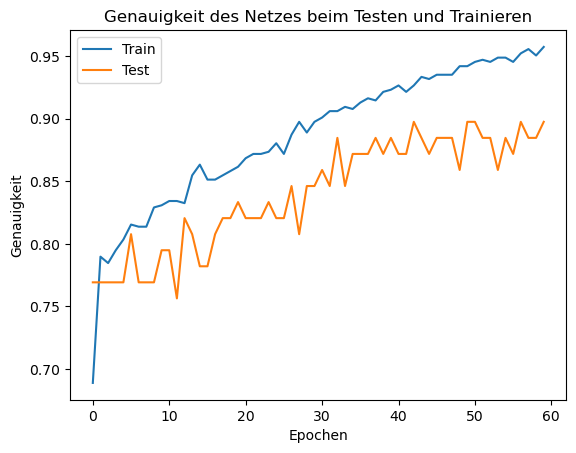

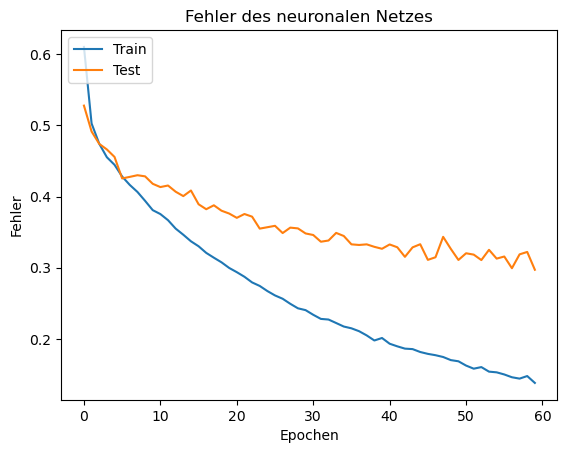

In [5]:
# graphische Darstellung der Genauigkeit beim Testen und Trainieren in Abhängigkeit der Anzahl der Epochen (show_graph_accurcay auf 1 setzen, um Graph zu zeigen)
show_graph_accuracy = 1

if show_graph_accuracy == 1:
    plt.plot(total_accuracy)
    plt.plot(total_val_accuracy)
    plt.title('Genauigkeit des Netzes beim Testen und Trainieren')
    plt.ylabel('Genauigkeit')
    plt.xlabel('Epochen')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
# graphische Darstellung des Verlustes beim Testen und Trainieren in Abhängigkeit der Anzahl der Epochen (show_graph_loss auf 1 setzen, um Graph zu zeigen)
show_graph_loss = 1

if show_graph_loss == 1:
    plt.plot(total_loss)
    plt.plot(total_val_loss)
    plt.title('Fehler des neuronalen Netzes')
    plt.ylabel('Fehler')
    plt.xlabel('Epochen')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()